In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import autograd.numpy as np
from scipy.stats import t 
from itertools import product
import pystan

from viabel.family import mean_field_t_variational_family
from viabel.models import make_stan_log_density
from viabel.optimization import adagrad_optimize
from experiments import *

sns.set_style('white')
sns.set_context('notebook', font_scale=2.5, rc={'lines.linewidth': 2})

# Eight Schools Model

For more details on this example, see:

[Practical posterior error bounds from variational objectives](https://arxiv.org/abs/1910.04102).
Jonathan H. Huggins,
Miko&#0322;aj Kasprzak,
Trevor Campbell,
Tamara Broderick.
In *Proc. of the 23rd International Conference on Artificial Intelligence and
Statistics* (AISTATS), Palermo, Italy. PMLR: Volume 108, 2020.

In [2]:
os.makedirs('../figures', exist_ok=True)

logtau_lim = [-2, 3.5]
mu_lim = [-5, 15]
theta1_lim = [-8, 22]

skip = 1 # how much to thin samples; larger values make the plots faster but let accurate 

In [3]:
def plot_sample_contours(x_samples1, y_samples1, x_samples2, y_samples2, xlabel, ylabel, xlim, ylim, 
                    cmap1, cmap2, savepath=None, **kwargs):
    sns.kdeplot(x_samples1, y_samples1, cmap=cmap1, **kwargs)
    sns.kdeplot(x_samples2, y_samples2, cmap=cmap2, **kwargs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def plot_sample_and_density_contours(x_samples, y_samples, logdensity, xlabel, ylabel, xlim, ylim, 
                    cmap_samples, cmap_density, savepath=None, **kwargs):
    sns.kdeplot(x_samples, y_samples, cmap=cmap_samples, **kwargs)
    x = np.linspace(*xlim, 100)
    y = np.linspace(*ylim, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    Z = np.exp(logdensity(XY))
    plt.contour(X, Y, Z, cmap=cmap_density, linestyles='solid')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks([])
    plt.yticks([])
    if savepath is not None:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()
    
def tranform_to_theta(ncp_samples):
    ncp_samples_tranformed = ncp_samples.copy()
    ncp_samples_tranformed[2:] = (ncp_samples_tranformed[0] 
                                  + np.exp(ncp_samples_tranformed[1]) * ncp_samples_tranformed[2:])
    return ncp_samples_tranformed

def get_ncp_approx_samples(var_family, opt_param, n_samples):
    ncp_samples = var_family.sample(opt_param, n_samples).T
    return ncp_samples, tranform_to_theta(ncp_samples)

## Model compilation and ground truth sampling

Compile Stan models

In [4]:
eight_schools_cp_stan_model = pystan.StanModel(file='eight_schools_cp.stan' ,
                                               model_name='eight_schools_cp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_cp_b061d14b15cea7d7e6cf0b7700a8b143 NOW.


In [5]:
eight_schools_ncp_stan_model = pystan.StanModel(file='eight_schools_ncp.stan',
                                                model_name='eight_schools_ncp')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL eight_schools_ncp_83f1609305e7267422b692fbee65a5db NOW.


Construct eight schools data and fit models. Note that fitting the centered parameterization model is problematic. 

In [6]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
data = dict(J=J, y=y, sigma=sigma)

In [7]:
eight_schools_cp_fit = eight_schools_cp_stan_model.sampling(data=data, iter=11000, warmup=1000,
                                                            control=dict(adapt_delta=.99))

In [8]:
eight_schools_ncp_fit = eight_schools_ncp_stan_model.sampling(data=data, iter=32000, warmup=2000, thin=3,
                                                              control=dict(adapt_delta=.95))

In [9]:
eight_schools_ncp_fit

Inference for Stan model: eight_schools_ncp_83f1609305e7267422b692fbee65a5db.
4 chains, each with iter=32000; warmup=2000; thin=3; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               4.41    0.02   3.31   -2.2    2.2   4.45   6.65  10.81  39759    1.0
tau              3.58    0.02   3.17   0.12   1.27   2.74   4.98  11.75  38469    1.0
theta_tilde[1]   0.33  4.9e-3   0.98  -1.62  -0.33   0.34   0.99   2.22  40469    1.0
theta_tilde[2]   0.09  4.6e-3   0.93  -1.76  -0.53   0.09   0.71   1.91  40787    1.0
theta_tilde[3]  -0.09  4.8e-3   0.97  -1.97  -0.74  -0.09   0.56   1.81  40783    1.0
theta_tilde[4]   0.07  4.7e-3   0.95   -1.8  -0.57   0.07    0.7   1.92  40784    1.0
theta_tilde[5]  -0.15  4.6e-3   0.93  -1.96  -0.78  -0.16   0.47   1.71  41080    1.0
theta_tilde[6]  -0.08  4.7e-3   0.95  -1.94  -0.72  -0.07   0.56   1.78  40840    1.0
theta_tilde[7]   0.35  4.8e

Record relevant information from both models and use samples from non-centered model as ground truth

In [10]:
# number of parameters and parameter names in centered model
n_params_cp = len(eight_schools_cp_fit.constrained_param_names())
param_names_cp = ['mu', 'log_tau'] + eight_schools_cp_fit.flatnames[2:n_params_cp]

# number of parameters and parameter names in non-centered model
n_params_ncp = len(eight_schools_ncp_fit.constrained_param_names())
param_names_ncp = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[2:n_params_ncp]
param_names_ncp_transformed = ['mu', 'log_tau'] + eight_schools_ncp_fit.flatnames[n_params_ncp:]

# the centered and tranformed non-centered parameters should be the same
np.testing.assert_array_equal(param_names_cp, param_names_ncp_transformed)

# construct matrix of samples (both original and transformed) from non-centered model 
samples_ncp_df = eight_schools_ncp_fit.to_dataframe(pars=eight_schools_ncp_fit.flatnames)
samples_ncp_df['log_tau'] = np.log(samples_ncp_df['tau'])
samples_ncp = samples_ncp_df.loc[:,param_names_ncp].values.T
samples_ncp_transformed = samples_ncp_df.loc[:,param_names_ncp_transformed].values.T

# use samples from non-centered model for ground true mean and covariance
true_mean_ncp = np.mean(samples_ncp, axis=1)
true_cov_ncp = np.cov(samples_ncp)
true_mean_ncp_tranformed = np.mean(samples_ncp_transformed, axis=1)
true_cov_ncp_tranformed = np.cov(samples_ncp_transformed)

## Variational inference for centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 8.5925: 100%|██████████| 10000/10000 [00:50<00:00, 198.87it/s]


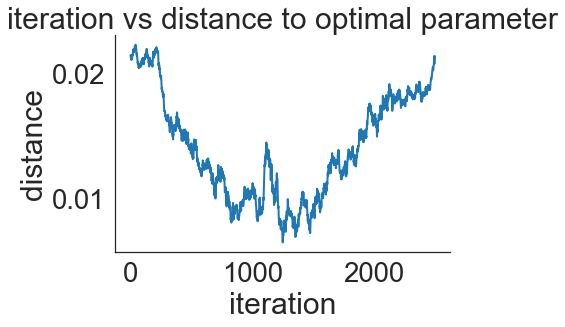

mean   = [4.2417714  1.76065714 6.94796913 5.09355441 3.52201209 4.77699119
 2.85903904 3.61849804 7.36043498 4.88726658]
stdevs = [1.80696767 0.24117792 5.14480183 4.81063413 5.18410306 4.89183434
 4.68911173 4.9136476  4.81334554 5.26171886]

mean error             = 1.9
stdev error            = 1.84
||cov error||_2^{1/2}  = 8.43
||true cov||_2^{1/2}   = 9.67

Computing CUBO and ELBO with 2500000 samples took 38.660 sec to run

Bounds on...
  2-Wasserstein   538
  2-divergence    11.5
  mean error      538
  stdev error     538
  sqrt cov error  764
  cov error       5.84e+05

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.906

mean   = [4.58250533 1.5241178  7.42926305 5.15782065 3.93361795 5.12894916
 3.31343722 3.92135147 7.26947179 5.39000228]
stdevs = [2.94238458 0.46436123 5.82182359 4.92554201 5.47393955 5.07524706
 4.69459991 5.06860873 5.27222878 5.70648285]

mean error             = 1.88
stdev error            = 1.11
||cov error||_2^{1/2}  = 5.34
||true cov||_2^{1/2}   = 9.67

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 9.2782: 100%|██████████| 10000/10000 [04:35<00:00, 36.23it/s]


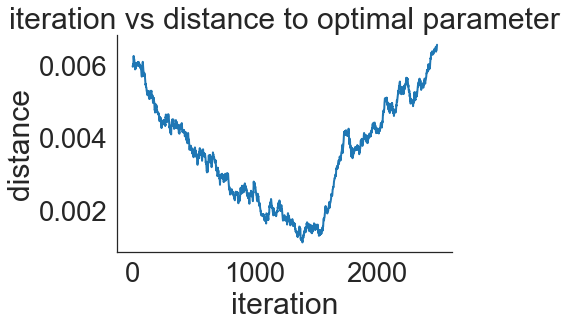

mean   = [4.39069191 0.9869041  6.23073006 4.91291961 3.93808448 4.78829374
 3.63527793 4.0144231  6.29129728 4.87963511]
stdevs = [3.02218277 1.15110312 5.45768005 4.70361522 5.22897122 4.80959833
 4.69212008 4.93088547 5.12691167 5.41077097]

mean error             = 0.189
stdev error            = 0.35
||cov error||_2^{1/2}  = 8.34
||true cov||_2^{1/2}   = 9.67

Computing CUBO and ELBO with 2500000 samples took 32.488 sec to run

Bounds on...
  2-Wasserstein   888
  2-divergence    13.4
  mean error      888
  stdev error     888
  sqrt cov error  1.26e+03
  cov error       1.59e+06

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.873

mean   = [4.25585134 1.16615729 6.16856524 4.94029204 3.8273879  4.779245
 3.43161216 3.82305917 6.29632491 4.72393212]
stdevs = [2.8470416  0.70017084 5.06013846 4.75818129 4.91874298 4.5854896
 4.40034273 4.66389871 4.80617399 5.13050897]

mean error             = 0.527
stdev error            = 0.994
||cov error||_2^{1/2}  = 5.29
||true cov||_2^{1/2}   = 9.67


In [11]:
eight_schools_cp_log_density = make_stan_log_density(eight_schools_cp_fit)
var_family_cp = mean_field_t_variational_family(n_params_cp, 40)

init_param_cp = np.concatenate([true_mean_ncp_tranformed, .5*np.log(np.diag(true_cov_ncp_tranformed))])
klvi_cp, chivi_cp, klvi_cp_results, chivi_cp_results, other_klvi_cp_results, other_chivi_cp_results = \
    run_experiment(eight_schools_cp_log_density, var_family_cp, init_param_cp, 
                   true_mean_ncp_tranformed, true_cov_ncp_tranformed, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=10000, bound_w2=2500000, verbose=True)

/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


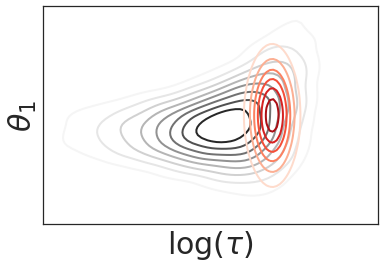

/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


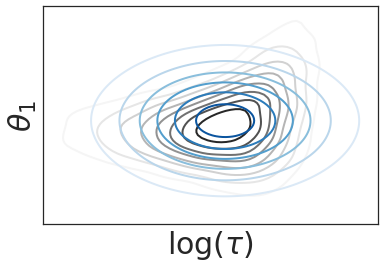

In [12]:
def cp_results_plot(other_results, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cp_opt_param = other_results['opt_param']
    cp_mean, cp_log_scale = cp_opt_param[:n_params_cp], cp_opt_param[n_params_cp:]
    cp_log_density = lambda x: np.sum(t.logpdf(x, 40, cp_mean[np.newaxis,np.newaxis,1:3], 
                                               np.exp(cp_log_scale[np.newaxis,np.newaxis,1:3])), axis=-1)
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_and_density_contours(
        np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip],
        cp_log_density, r'$\log(\tau)$', r'$\theta_1$', 
        logtau_lim, theta1_lim, 'Greys', cmap2,
        '../figures/8-schools-cp-log-tau-vs-theta1-{}.pdf'.format(method))

cp_results_plot(other_klvi_cp_results, 'klvi')
cp_results_plot(other_chivi_cp_results, 'chivi')

## Variational inference for non-centered model (df = 40)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 6.8108: 100%|██████████| 5000/5000 [00:22<00:00, 218.25it/s]


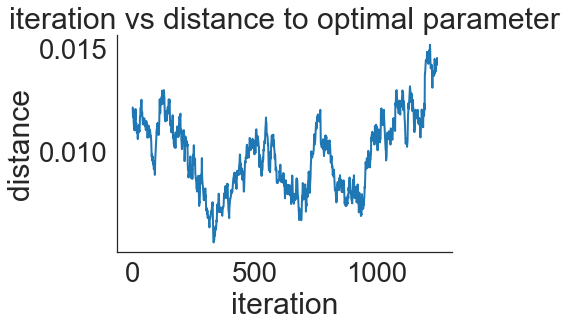

mean   = [ 4.52297255  0.80229379  0.28909886  0.08663662 -0.07788453  0.05214457
 -0.17233957 -0.07572135  0.34607738  0.0638606 ]
stdevs = [3.17440095 0.73041172 0.96470518 0.93607029 0.97227257 0.94551839
 0.91889603 0.93926205 0.93228689 0.97817989]

mean error             = 0.126
stdev error            = 0.467
||cov error||_2^{1/2}  = 1.21
||true cov||_2^{1/2}   = 3.32

Computing CUBO and ELBO with 2500000 samples took 31.093 sec to run

Bounds on...
  2-Wasserstein   25.3
  2-divergence    3.86
  mean error      25.3
  stdev error     25.3
  sqrt cov error  37.9
  cov error       1.44e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.649

mean   = [ 4.39907757  0.8488704   0.31843187  0.09926721 -0.08558902  0.06672552
 -0.16268189 -0.07638885  0.35977978  0.07624626]
stdevs = [3.33121762 1.06915218 0.98401739 0.93653414 0.96964965 0.94444592
 0.92894834 0.94193706 0.95946557 0.97161371]

mean error             = 0.0534
stdev error            = 0.11
||cov error||_2^{1/2}  = 0.499
||true cov||_2^{1/2}   = 3.32

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2272: 100%|██████████| 5000/5000 [02:39<00:00, 31.44it/s]


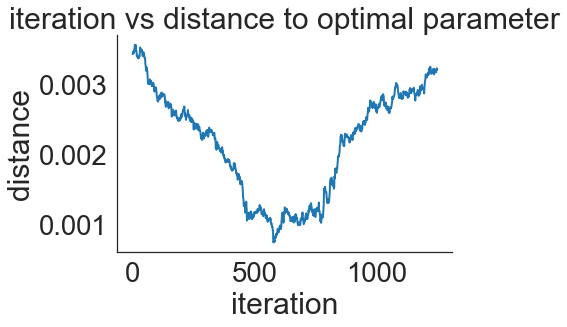

mean   = [ 4.40655135  0.94886376  0.34539997  0.10013125 -0.0994841   0.06147658
 -0.1757132  -0.07825597  0.37714754  0.07831242]
stdevs = [3.3517285  1.12302404 0.99709802 0.93963047 0.9680195  0.9441208
 0.93355669 0.94483951 0.97209561 0.97326324]

mean error             = 0.156
stdev error            = 0.073
||cov error||_2^{1/2}  = 0.943
||true cov||_2^{1/2}   = 3.32

Computing CUBO and ELBO with 2500000 samples took 39.716 sec to run

Bounds on...
  2-Wasserstein   14.7
  2-divergence    1.65
  mean error      14.7
  stdev error     14.7
  sqrt cov error  23
  cov error       529

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.563

mean   = [ 4.39632391  0.80230849  0.3189443   0.09801894 -0.08285864  0.0626727
 -0.16408701 -0.07204285  0.35696348  0.07640945]
stdevs = [3.30507864 1.16366488 0.98964967 0.93797523 0.96933742 0.94402748
 0.93114663 0.94234643 0.95919721 0.97410455]

mean error             = 0.0213
stdev error            = 0.0221
||cov error||_2^{1/2}  = 0.237
||true cov||_2^{1/2}   = 3.32


In [13]:
eight_schools_ncp_log_density = make_stan_log_density(eight_schools_ncp_fit)
var_family_ncp = mean_field_t_variational_family(n_params_ncp, 40)

init_param_ncp = np.concatenate([true_mean_ncp, .5*np.log(np.diag(true_cov_ncp))])
klvi_ncp, chivi_ncp, klvi_ncp_results, chivi_ncp_results, other_klvi_ncp_results, other_chivi_ncp_results = \
    run_experiment(eight_schools_ncp_log_density, var_family_ncp, init_param_ncp, true_mean_ncp, true_cov_ncp, 
                   learning_rate=.01, learning_rate_end=.001,
                   n_iters=5000, bound_w2=2500000, verbose=True)

In [14]:
n_samples = eight_schools_ncp_fit['tau'][::skip].size
klvi_ncp_samples, klvi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_klvi_ncp_results['opt_param'], n_samples)
chivi_ncp_samples, chivi_ncp_samples_tranformed = \
    get_ncp_approx_samples(var_family_ncp, other_chivi_ncp_results['opt_param'], n_samples)

/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


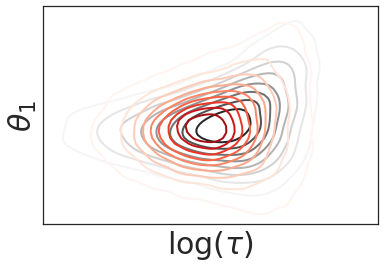

/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/restructure-temp/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


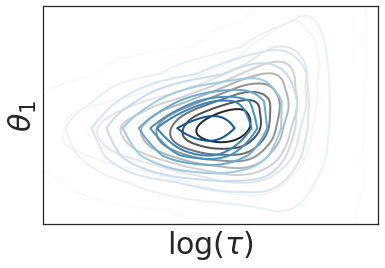

In [15]:
def plot_cp_results(ncp_samples_tranformed, method):
    if method not in ['klvi', 'chivi']:
        print('invalid method "{}"'.format(method))
        return
    cmap2 = 'Reds' if method == 'klvi' else 'Blues'
    plot_sample_contours(np.log(eight_schools_ncp_fit['tau'][::skip]), eight_schools_ncp_fit['theta[1]'][::skip], 
                         ncp_samples_tranformed[1], ncp_samples_tranformed[2], 
                         r'$\log(\tau)$', r'$\theta_1$', 
                         logtau_lim, theta1_lim, 'Greys', cmap2,
                         '../figures/8-schools-ncp-log-tau-vs-theta1-{}.pdf'.format(method))
plot_cp_results(klvi_ncp_samples_tranformed, 'klvi')
plot_cp_results(chivi_ncp_samples_tranformed, 'chivi')

## Variational inference for non-centered model (df=8)

|--------------|
|     KLVI     |
|--------------|


Average Loss = 8.1145: 100%|██████████| 5000/5000 [00:26<00:00, 189.04it/s]


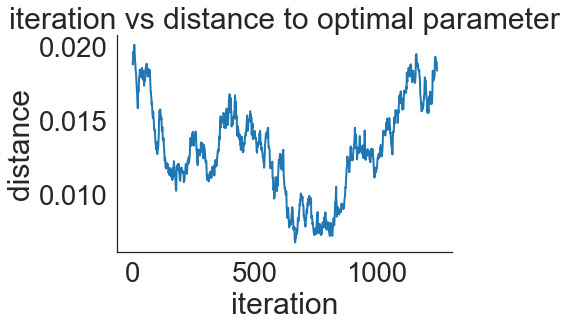

mean   = [ 4.53669557  0.8291022   0.28800741  0.08534955 -0.08049588  0.05237469
 -0.16396145 -0.07391151  0.33669971  0.05897454]
stdevs = [3.1678536  0.67665925 0.96828316 0.93322093 0.97137034 0.94208398
 0.92026413 0.94316386 0.93031668 0.97624307]

mean error             = 0.143
stdev error            = 0.52
||cov error||_2^{1/2}  = 1.23
||true cov||_2^{1/2}   = 3.32



/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/viabel/bounds.py:191: UserWarning: significant Monte Carlo error when computing ELBO (mean = 6.365822298893345, standard deviation = 0.41751184299662436)
  warn(msg)


Computing CUBO and ELBO with 2500000 samples took 40.547 sec to run

Bounds on...
  2-Wasserstein   36.7
  2-divergence    5.11
  mean error      36.7
  stdev error     36.7
  sqrt cov error  54.1
  cov error       2.93e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.583

mean   = [ 4.38439221  0.80150547  0.31869523  0.09325687 -0.08296946  0.06040991
 -0.16215451 -0.07249625  0.35652625  0.07989993]
stdevs = [3.33824405 1.17894385 0.98825606 0.93632186 0.96764367 0.94461193
 0.92969523 0.94169212 0.96331655 0.97736942]

mean error             = 0.0275
stdev error            = 0.035
||cov error||_2^{1/2}  = 0.479
||true cov||_2^{1/2}   = 3.32

|---------------|
|     CHIVI     |
|---------------|


Average Loss = 8.2271: 100%|██████████| 5000/5000 [02:02<00:00, 40.91it/s]


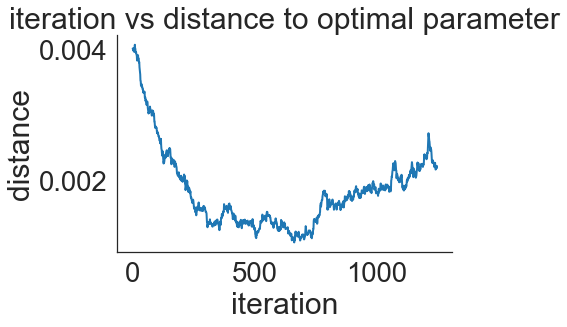

mean   = [ 4.40866985  0.97732305  0.333004    0.09424156 -0.0928236   0.05942324
 -0.17326305 -0.08149987  0.36782354  0.07795412]
stdevs = [3.52337702 1.23609852 1.05279827 0.98460623 1.02359421 0.98912189
 0.98069672 0.9910134  1.02252684 1.02504919]

mean error             = 0.181
stdev error            = 0.271
||cov error||_2^{1/2}  = 1.34
||true cov||_2^{1/2}   = 3.32

Computing CUBO and ELBO with 2500000 samples took 27.229 sec to run

Bounds on...
  2-Wasserstein   29.4
  2-divergence    3.81
  mean error      29.4
  stdev error     29.4
  sqrt cov error  44
  cov error       1.94e+03

Results with PSIS correction
----------------------------


/Users/jhuggins/Dropbox (Personal)/Research/Projects/_public repos/viabel/notebooks/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


khat = 0.395

mean   = [ 4.39554755  0.80404339  0.31817338  0.0964295  -0.08373462  0.06179802
 -0.16001518 -0.07415936  0.35679271  0.07562936]
stdevs = [3.31979955 1.1689701  0.98895593 0.93872719 0.96829182 0.94360697
 0.93035022 0.94361658 0.96032496 0.97566179]

mean error             = 0.0196
stdev error            = 0.0221
||cov error||_2^{1/2}  = 0.313
||true cov||_2^{1/2}   = 3.32


In [16]:
var_family_ncp_8 = mean_field_t_variational_family(n_params_ncp, 8)
run_experiment(eight_schools_ncp_log_density, var_family_ncp_8, init_param_ncp, true_mean_ncp, true_cov_ncp, 
               learning_rate=.01, learning_rate_end=.001,
               n_iters=5000, bound_w2=2500000, verbose=True);